In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
from math import pi

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

In [2]:

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import numpy as np

fig = Figure()
canvas = FigureCanvas(fig)
ax = fig.gca()

ax.text(0.0,0.0,"Test", fontsize=45)
ax.axis('off')

canvas.draw()       # draw the canvas, cache the renderer

image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')

In [6]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import numpy as np
from PIL import Image


fig = Figure(figsize=(5, 4), dpi=100)
# A canvas must be manually attached to the figure (pyplot would automatically
# do it).  This is done by instantiating the canvas with the figure as
# argument.
canvas = FigureCanvasAgg(fig)

# Do some plotting.
ax = fig.add_subplot()
ax.plot([1, 2, 3])

# Option 1: Save the figure to a file; can also be a file-like object (BytesIO,
# etc.).
# fig.savefig("test.png")

# Option 2: Retrieve a memoryview on the renderer buffer, and convert it to a
# numpy array.
canvas.draw()
rgba = np.asarray(canvas.buffer_rgba())
# ... and pass it to PIL.
im = Image.fromarray(rgba)
# This image can then be saved to any format supported by Pillow, e.g.:
# im.save("test.bmp")

# Uncomment this line to display the image using ImageMagick's `display` tool.
# im.show()

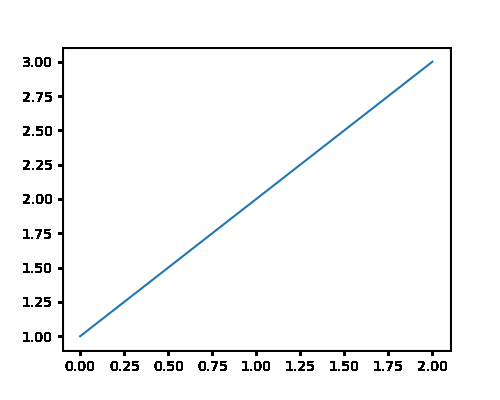

In [26]:
Image.fromarray(rgba[:,:,:3])

C:\Users\chika\.conda\envs\SlideStyleTransfer\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


TypeError: Invalid shape (921600,) for image data

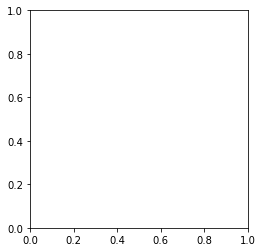

In [4]:
import skimage
skimage.io.imshow(image)

In [13]:
input_embedding_num = 64
slide_deck_embedding_num = 128
output_label_num = 4
hidden_state_num = 128
content_num = 32
batch_size = 2

input_embedding = torch.randn((batch_size, input_embedding_num))
slide_deck_embedding = torch.randn((batch_size, slide_deck_embedding_num))
content = torch.randn((batch_size, content_num))

x = torch.cat([input_embedding, slide_deck_embedding, content], 1)
print(x.shape)

torch.Size([2, 224])


In [ ]:

class BoxGenerator(torch.nn.module):
    def __init__(self, input_embedding_num, slide_deck_embedding_num, output_label_num, hidden_state_num, content_num, K=2):
        self.lstm = nn.LSTM(input_size=input_embedding_num + slide_deck_embedding_num + content_num, hidden_size=hidden_state_num, batch_first=True)
        self.W1 = nn.Linear(hidden_state_num + content_num, output_label_num)
        self.W2 = nn.Linear(output_label_num + hidden_state_num, 4)


    def forward(self, x):
        output_1 = self.lstm(x)
        temp = torch.cat(W1,)
        label = self.W1(output_1, x[:,])

        

class GaussianMixture(torch.nn.Module):
    """
    Fits a mixture of k=1,..,K Gaussians to the input data (K is supplied via n_components).
    Input tensors are expected to be flat with dimensions (n: number of samples, d: number of features).
    The model then extends them to (n, 1, d).
    The model parametrization (mu, sigma) is stored as (1, k, d),
    probabilities are shaped (n, k, 1) if they relate to an individual sample,
    or (1, k, 1) if they assign membership probabilities to one of the mixture components.
    """
    def __init__(self, n_components, n_features, covariance_type="full", eps=1.e-6, init_params="kmeans", mu_init=None, var_init=None):
        """
        Initializes the model and brings all tensors into their required shape.
        The class expects data to be fed as a flat tensor in (n, d).
        The class owns:
            x:               torch.Tensor (n, 1, d)
            mu:              torch.Tensor (1, k, d)
            var:             torch.Tensor (1, k, d) or (1, k, d, d)
            pi:              torch.Tensor (1, k, 1)
            covariance_type: str
            eps:             float
            init_params:     str
            log_likelihood:  float
            n_components:    int
            n_features:      int
        args:
            n_components:    int
            n_features:      int
        options:
            mu_init:         torch.Tensor (1, k, d)
            var_init:        torch.Tensor (1, k, d) or (1, k, d, d)
            covariance_type: str
            eps:             float
            init_params:     str
        """
        super(GaussianMixture, self).__init__()

        self.n_components = n_components
        self.n_features = n_features

        self.mu_init = mu_init
        self.var_init = var_init
        self.eps = eps

        self.log_likelihood = -np.inf

        self.covariance_type = covariance_type
        self.init_params = init_params

        assert self.covariance_type in ["full", "diag"]
        assert self.init_params in ["kmeans", "random"]

        self._init_params()


    def _init_params(self):
        if self.mu_init is not None:
            assert self.mu_init.size() == (1, self.n_components, self.n_features), "Input mu_init does not have required tensor dimensions (1, %i, %i)" % (self.n_components, self.n_features)
            # (1, k, d)
            self.mu = torch.nn.Parameter(self.mu_init, requires_grad=False)
        else:
            self.mu = torch.nn.Parameter(torch.randn(1, self.n_components, self.n_features), requires_grad=False)

        if self.covariance_type == "diag":
            if self.var_init is not None:
                # (1, k, d)
                assert self.var_init.size() == (1, self.n_components, self.n_features), "Input var_init does not have required tensor dimensions (1, %i, %i)" % (self.n_components, self.n_features)
                self.var = torch.nn.Parameter(self.var_init, requires_grad=False)
            else:
                self.var = torch.nn.Parameter(torch.ones(1, self.n_components, self.n_features), requires_grad=False)
        elif self.covariance_type == "full":
            if self.var_init is not None:
                # (1, k, d, d)
                assert self.var_init.size() == (1, self.n_components, self.n_features, self.n_features), "Input var_init does not have required tensor dimensions (1, %i, %i, %i)" % (self.n_components, self.n_features, self.n_features)
                self.var = torch.nn.Parameter(self.var_init, requires_grad=False,)
            else:
                self.var = torch.nn.Parameter(
                    torch.eye(self.n_features,dtype=torch.float64).reshape(1, 1, self.n_features, self.n_features).repeat(1, self.n_components, 1, 1),
                    requires_grad=False)

        # (1, k, 1)
        self.pi = torch.nn.Parameter(torch.Tensor(1, self.n_components, 1), requires_grad=False).fill_(1. / self.n_components)

        self.params_fitted = False


    def check_size(self, x):
        if len(x.size()) == 2:
            # (n, d) --> (n, 1, d)
            x = x.unsqueeze(1)

        return x


    def bic(self, x):
        """
        Bayesian information criterion for a batch of samples.
        args:
            x:      torch.Tensor (n, d) or (n, 1, d)
        returns:
            bic:    float
        """
        x = self.check_size(x)
        n = x.shape[0]

        # Free parameters for covariance, means and mixture components
        free_params = self.n_features * self.n_components + self.n_features + self.n_components - 1

        bic = -2. * self.__score(x, as_average=False).mean() * n + free_params * np.log(n)

        return bic


    def fit(self, x, delta=1e-3, n_iter=100, warm_start=False):
        """
        Fits model to the data.
        args:
            x:          torch.Tensor (n, d) or (n, k, d)
        options:
            delta:      float
            n_iter:     int
            warm_start: bool
        """
        if not warm_start and self.params_fitted:
            self._init_params()

        x = self.check_size(x)

        if self.init_params == "kmeans" and self.mu_init is None:
            mu = self.get_kmeans_mu(x, n_centers=self.n_components)
            self.mu.data = mu

        i = 0
        j = np.inf

        while (i <= n_iter) and (j >= delta):

            log_likelihood_old = self.log_likelihood
            mu_old = self.mu
            var_old = self.var

            self.__em(x)
            self.log_likelihood = self.__score(x)

            if torch.isinf(self.log_likelihood.abs()) or torch.isnan(self.log_likelihood):
                device = self.mu.device
                # When the log-likelihood assumes inane values, reinitialize model
                self.__init__(self.n_components,
                    self.n_features,
                    covariance_type=self.covariance_type,
                    mu_init=self.mu_init,
                    var_init=self.var_init,
                    eps=self.eps)
                for p in self.parameters():
                    p.data = p.data.to(device)
                if self.init_params == "kmeans":
                    self.mu.data, = self.get_kmeans_mu(x, n_centers=self.n_components)

            i += 1
            j = self.log_likelihood - log_likelihood_old

            if j <= delta:
                # When score decreases, revert to old parameters
                self.__update_mu(mu_old)
                self.__update_var(var_old)

        self.params_fitted = True


    def predict(self, x, probs=False):
        """
        Assigns input data to one of the mixture components by evaluating the likelihood under each.
        If probs=True returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
            probs:      bool
        returns:
            p_k:        torch.Tensor (n, k)
            (or)
            y:          torch.LongTensor (n)
        """
        x = self.check_size(x)

        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)

        if probs:
            p_k = torch.exp(weighted_log_prob)
            return torch.squeeze(p_k / (p_k.sum(1, keepdim=True)))
        else:
            return torch.squeeze(torch.max(weighted_log_prob, 1)[1].type(torch.LongTensor))


    def predict_proba(self, x):
        """
        Returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
        returns:
            y:          torch.LongTensor (n)
        """
        return self.predict(x, probs=True)


    def score_samples(self, x):
        """
        Computes log-likelihood of samples under the current model.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
        returns:
            score:      torch.LongTensor (n)
        """
        x = self.check_size(x)

        score = self.__score(x, as_average=False)
        return score


    def _estimate_log_prob(self, x):
        """
        Returns a tensor with dimensions (n, k, 1), which indicates the log-likelihood that samples belong to the k-th Gaussian.
        args:
            x:            torch.Tensor (n, d) or (n, 1, d)
        returns:
            log_prob:     torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)

        if self.covariance_type == "full":
            mu = self.mu
            var = self.var
            precision = torch.inverse(var)
            d = x.shape[-1]

            log_2pi = d * np.log(2. * pi)

            log_det = self._calculate_log_det(precision)

            x = x.double() 
            mu = mu.double()
            x_mu_T = (x - mu).unsqueeze(-2)
            x_mu = (x - mu).unsqueeze(-1)

            x_mu_T_precision = calculate_matmul_n_times(self.n_components, x_mu_T, precision)
            x_mu_T_precision_x_mu = calculate_matmul(x_mu_T_precision, x_mu)

            return -.5 * (log_2pi - log_det + x_mu_T_precision_x_mu)

        elif self.covariance_type == "diag":
            mu = self.mu
            prec = torch.rsqrt(self.var)

            log_p = torch.sum((mu * mu + x * x - 2 * x * mu) * (prec ** 2), dim=2, keepdim=True)
            log_det = torch.sum(torch.log(prec), dim=2, keepdim=True)

            return -.5 * (self.n_features * np.log(2. * pi) + log_p) + log_det



    def _calculate_log_det(self, var):
        """
        Calculate log determinant in log space, to prevent overflow errors.
        args:
            var:            torch.Tensor (1, k, d, d)
        """
        log_det = torch.empty(size=(self.n_components,)).to(var.device)
        
        for k in range(self.n_components):
            log_det[k] = 2 * torch.log(torch.diagonal(torch.linalg.cholesky(var[0,k]))).sum()

        return log_det.unsqueeze(-1)


    def _e_step(self, x):
        """
        Computes log-responses that indicate the (logarithmic) posterior belief (sometimes called responsibilities) that a data point was generated by one of the k mixture components.
        Also returns the mean of the mean of the logarithms of the probabilities (as is done in sklearn).
        This is the so-called expectation step of the EM-algorithm.
        args:
            x:              torch.Tensor (n, d) or (n, 1, d)
        returns:
            log_prob_norm:  torch.Tensor (1)
            log_resp:       torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)

        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)

        log_prob_norm = torch.logsumexp(weighted_log_prob, dim=1, keepdim=True)
        log_resp = weighted_log_prob - log_prob_norm

        return torch.mean(log_prob_norm), log_resp


    def _m_step(self, x, log_resp):
        """
        From the log-probabilities, computes new parameters pi, mu, var (that maximize the log-likelihood). This is the maximization step of the EM-algorithm.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
            log_resp:   torch.Tensor (n, k, 1)
        returns:
            pi:         torch.Tensor (1, k, 1)
            mu:         torch.Tensor (1, k, d)
            var:        torch.Tensor (1, k, d)
        """
        x = self.check_size(x)

        resp = torch.exp(log_resp)

        pi = torch.sum(resp, dim=0, keepdim=True) + self.eps
        mu = torch.sum(resp * x, dim=0, keepdim=True) / pi

        if self.covariance_type == "full":
            eps = (torch.eye(self.n_features) * self.eps).to(x.device)
            var = torch.sum((x - mu).unsqueeze(-1).matmul((x - mu).unsqueeze(-2)) * resp.unsqueeze(-1), dim=0,
                            keepdim=True) / torch.sum(resp, dim=0, keepdim=True).unsqueeze(-1) + eps
        elif self.covariance_type == "diag":
            x2 = (resp * x * x).sum(0, keepdim=True) / pi
            mu2 = mu * mu
            xmu = (resp * mu * x).sum(0, keepdim=True) / pi
            var = x2 - 2 * xmu + mu2 + self.eps

        pi = pi / x.shape[0]

        return pi, mu, var


    def __em(self, x):
        """
        Performs one iteration of the expectation-maximization algorithm by calling the respective subroutines.
        args:
            x:          torch.Tensor (n, 1, d)
        """
        _, log_resp = self._e_step(x)
        pi, mu, var = self._m_step(x, log_resp)

        self.__update_pi(pi)
        self.__update_mu(mu)
        self.__update_var(var)


    def __score(self, x, as_average=True):
        """
        Computes the log-likelihood of the data under the model.
        args:
            x:                  torch.Tensor (n, 1, d)
            sum_data:           bool
        returns:
            score:              torch.Tensor (1)
            (or)
            per_sample_score:   torch.Tensor (n)
        """
        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)
        per_sample_score = torch.logsumexp(weighted_log_prob, dim=1)

        if as_average:
            return per_sample_score.mean()
        else:
            return torch.squeeze(per_sample_score)


    def __update_mu(self, mu):
        """
        Updates mean to the provided value.
        args:
            mu:         torch.FloatTensor
        """
        assert mu.size() in [(self.n_components, self.n_features), (1, self.n_components, self.n_features)], "Input mu does not have required tensor dimensions (%i, %i) or (1, %i, %i)" % (self.n_components, self.n_features, self.n_components, self.n_features)

        if mu.size() == (self.n_components, self.n_features):
            self.mu = mu.unsqueeze(0)
        elif mu.size() == (1, self.n_components, self.n_features):
            self.mu.data = mu


    def __update_var(self, var):
        """
        Updates variance to the provided value.
        args:
            var:        torch.FloatTensor
        """
        if self.covariance_type == "full":
            assert var.size() in [(self.n_components, self.n_features, self.n_features), (1, self.n_components, self.n_features, self.n_features)], "Input var does not have required tensor dimensions (%i, %i, %i) or (1, %i, %i, %i)" % (self.n_components, self.n_features, self.n_features, self.n_components, self.n_features, self.n_features)

            if var.size() == (self.n_components, self.n_features, self.n_features):
                self.var = var.unsqueeze(0)
            elif var.size() == (1, self.n_components, self.n_features, self.n_features):
                self.var.data = var

        elif self.covariance_type == "diag":
            assert var.size() in [(self.n_components, self.n_features), (1, self.n_components, self.n_features)], "Input var does not have required tensor dimensions (%i, %i) or (1, %i, %i)" % (self.n_components, self.n_features, self.n_components, self.n_features)

            if var.size() == (self.n_components, self.n_features):
                self.var = var.unsqueeze(0)
            elif var.size() == (1, self.n_components, self.n_features):
                self.var.data = var


    def __update_pi(self, pi):
        """
        Updates pi to the provided value.
        args:
            pi:         torch.FloatTensor
        """
        assert pi.size() in [(1, self.n_components, 1)], "Input pi does not have required tensor dimensions (%i, %i, %i)" % (1, self.n_components, 1)

        self.pi.data = pi


    def get_kmeans_mu(self, x, n_centers, init_times=50, min_delta=1e-3):
        """
        Find an initial value for the mean. Requires a threshold min_delta for the k-means algorithm to stop iterating.
        The algorithm is repeated init_times often, after which the best centerpoint is returned.
        args:
            x:            torch.FloatTensor (n, d) or (n, 1, d)
            init_times:   init
            min_delta:    int
        """
        if len(x.size()) == 3:
            x = x.squeeze(1)
        x_min, x_max = x.min(), x.max()
        x = (x - x_min) / (x_max - x_min)
        
        min_cost = np.inf

        for i in range(init_times):
            tmp_center = x[np.random.choice(np.arange(x.shape[0]), size=n_centers, replace=False), ...]
            l2_dis = torch.norm((x.unsqueeze(1).repeat(1, n_centers, 1) - tmp_center), p=2, dim=2)
            l2_cls = torch.argmin(l2_dis, dim=1)

            cost = 0
            for c in range(n_centers):
                cost += torch.norm(x[l2_cls == c] - tmp_center[c], p=2, dim=1).mean()

            if cost < min_cost:
                min_cost = cost
                center = tmp_center

        delta = np.inf

        while delta > min_delta:
            l2_dis = torch.norm((x.unsqueeze(1).repeat(1, n_centers, 1) - center), p=2, dim=2)
            l2_cls = torch.argmin(l2_dis, dim=1)
            center_old = center.clone()

            for c in range(n_centers):
                center[c] = x[l2_cls == c].mean(dim=0)

            delta = torch.norm((center_old - center), dim=1).max()

        return (center.unsqueeze(0)*(x_max - x_min) + x_min)
